In [1]:
!pip install -q tensorflow
!pip install -q python-dotenv kagglehub scipy albumentations

In [2]:
import os
from dotenv import load_dotenv
from google.colab import drive
import kagglehub
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import albumentations as A
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, applications
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2DTranspose, Concatenate, Conv2D, Input, Dropout, Concatenate
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from scipy.ndimage import label as connected_components
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from collections import Counter
from keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tensorflow.keras.metrics import AUC

# SET ENVIRONMENT

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

# Define the correct path
dotenv_path = "/content/drive/MyDrive/Colab Notebooks/.env"

# Load the .env file
load_dotenv(dotenv_path)

# Set Kaggle credentials for kagglehub
os.environ["KAGGLE_USERNAME"] = os.getenv("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = os.getenv("KAGGLE_KEY")

Mounted at /content/drive


# DOWNLOAD DATASET

In [4]:
# Download latest version
path = kagglehub.dataset_download("ultralytics/brain-tumor")

print("Path to dataset files:", path)
print("Files in dataset folder:", os.listdir(path))

TRAIN_IMAGES_PATH = os.path.join(path,"brain-tumor/train/images")
TRAIN_LABELS_PATH = os.path.join(path,"brain-tumor/train/labels")
VALID_IMAGES_PATH = os.path.join(path,"brain-tumor/valid/images")
VALID_LABELS_PATH = os.path.join(path,"brain-tumor/valid/labels")

IMG_SIZE = 224

100%|██████████| 4.19M/4.19M [00:00<00:00, 104MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ultralytics/brain-tumor/versions/2
Files in dataset folder: ['brain-tumor', 'brain-tumor.yaml']


In [5]:
cnn1_images_path = "/content/cnn1"
cnn2_images_path = "/content/cnn2"

# Define the new folder structure
base_dirs = [cnn1_images_path, cnn2_images_path]
sub_dirs = ["train", "valid"]

# Create both folders with subdirectories
for base_dir in base_dirs:
    for sub_dir in sub_dirs:
        os.makedirs(os.path.join(base_dir, sub_dir), exist_ok=True)

print("Folders cnn1 and cnn2 with subfolders train and valid have been created.")

Folders cnn1 and cnn2 with subfolders train and valid have been created.


# DATA PREPROCESSING

In [6]:
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),                  # 50% chance to flip horizontally. Tumors can appear on either side of the brain. This simulates left-right variability
    A.RandomBrightnessContrast(p=0.2),        # Adjust brightness/contrast with 20% probability. It simulates different imaging conditions (e.g., variations in scanner settings), helping the model become robust to changes in lighting.
    A.Rotate(limit=15, p=0.3),                # Rotate by a small angle (±15°) with 30% probability. MRI scans may have slight angular differences due to patient positioning. Small rotations ensure the model learns to recognize tumors even if they're not perfectly aligned.
    A.GaussianBlur(p=0.1)                     # Simulates minor noise or imperfections in imaging. It can help the model generalize better by not overfitting to overly sharp features.
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels'])) # Format-"pascal-voc" indicates that the bounding boxes are in the (x1, y1, x2, y2) format.

def preprocess_brain_image_with_boxes(image, bboxes, padding=10, img_shape=(IMG_SIZE, IMG_SIZE)):
  if image is None:
        return None, None  # to be skipped safely

  original_h, original_w = image.shape[:2]
  # Convert to grayscale if needed
  if len(image.shape) == 3:
      image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  else:
      image_gray = image

  # Binary threshold to isolate brain
  _, thresh = cv2.threshold(image_gray, 10, 255, cv2.THRESH_BINARY)
  contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  bbox_preprocessed = []

  # CASE 1: No contours detected — just resize and adjust YOLO boxes to (x1, y1, x2, y2)
  if not contours:
      image_preprocessed = cv2.resize(image, img_shape, interpolation=cv2.INTER_LANCZOS4)
      for bbox in bboxes:
        x_center, y_center, box_width, box_height = bbox
        # Scale and position the center to the resized image dimensions (IMG_SIZE) in pixels.
        x_center_new = (x_center * IMG_SIZE)
        y_center_new = (y_center * IMG_SIZE)
        box_width_new = (box_width * IMG_SIZE)
        box_height_new = (box_height * IMG_SIZE)

        # Convert from YOLO format to (x1, y1, x2, y2)
        x1 = x_center_new - (box_width_new / 2)
        y1 = y_center_new - (box_height_new / 2)
        x2 = x_center_new + (box_width_new / 2)
        y2 = y_center_new + (box_height_new / 2)
        bbox_preprocessed.append([x1,y1,x2,y2])
      return image_preprocessed, bbox_preprocessed

  # CASE 2: Contours detected to remove black background — crop and adjust boxes accordingly
  brain_x, brain_y, brain_w, brain_h = cv2.boundingRect(max(contours, key=cv2.contourArea))
  crop_x1 = max(0, brain_x - padding)
  crop_y1 = max(0, brain_y - padding)
  crop_x2 = min(brain_x + brain_w + padding, original_w)
  crop_y2 = min(brain_y + brain_h + padding, original_h)

  cropped = image[crop_y1:crop_y2, crop_x1:crop_x2]
  image_preprocessed = cv2.resize(cropped, img_shape, interpolation=cv2.INTER_LANCZOS4)

  crop_w = crop_x2 - crop_x1
  crop_h = crop_y2 - crop_y1

  for bbox in bboxes:
    x_center, y_center, box_width, box_height = bbox

    # Convert to pixel coordinates in original image
    x_center_px = x_center * original_w
    y_center_px = y_center * original_h
    box_width_px = box_width * original_w
    box_height_px = box_height * original_h

    # Convert to x1, y1, x2, y2
    x1 = x_center_px - box_width_px / 2
    y1 = y_center_px - box_height_px / 2
    x2 = x_center_px + box_width_px / 2
    y2 = y_center_px + box_height_px / 2

    # Shift according to crop
    x1 -= crop_x1
    x2 -= crop_x1
    y1 -= crop_y1
    y2 -= crop_y1

    # Resize to img_shape
    x1 = x1 * IMG_SIZE / crop_w
    x2 = x2 * IMG_SIZE / crop_w
    y1 = y1 * IMG_SIZE / crop_h
    y2 = y2 * IMG_SIZE / crop_h

    bbox_preprocessed.append([x1, y1, x2, y2])

  return image_preprocessed, bbox_preprocessed


def refine_bbox_mask(image, bbox):
    x1, y1, x2, y2 = map(int, bbox)
    crop = image[y1:y2, x1:x2]

    # Convert to grayscale if needed
    if crop.ndim == 3:
        gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    else:
        gray = crop

    # CLAHE for local contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)

    # Binarize using Otsu
    _, binary = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an empty mask for the crop
    mask_crop = np.zeros_like(binary)

    # Fill all contours (i.e. fill the tumor!)
    cv2.drawContours(mask_crop, contours, -1, 255, thickness=cv2.FILLED)

    # Morphological closing using OpenCV (fill gaps and smooth)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))  # Disk-shaped kernel
    mask_crop_filled = cv2.morphologyEx(mask_crop, cv2.MORPH_CLOSE, kernel)


    # Insert the crop back into a full-size mask
    full_mask = np.zeros(image.shape[:2], dtype=np.uint8)
    full_mask[y1:y2, x1:x2] = mask_crop_filled

    return full_mask


def create_dataframe(image_path, label_path, data_type):
    data = []

    for img_name in os.listdir(image_path):
        img_full_path = os.path.join(image_path, img_name)
        label_full_path = os.path.join(label_path, img_name.replace('.jpg', '.txt'))

        image = cv2.imread(img_full_path)
        class_ids = []
        bboxes = []

        if not os.path.exists(label_full_path):
          continue  # Skip this image if its label file is missing

        with open(label_full_path, 'r') as file:
            for line in file:
                values = line.strip().split()
                class_id = int(values[0])
                bbox = list(map(float, values[1:]))

                class_ids.append(class_id)
                bboxes.append(bbox)

        # Preprocess image
        image_preprocessed, bbox_preprocessed = preprocess_brain_image_with_boxes(image, bboxes)
        # Augment image
        augmented = augmentation(image=image_preprocessed, bboxes=bbox_preprocessed, class_labels=class_ids)

        # Normalizing the bboxes to a range of [0..1] and rounding to 6 decimals
        bboxes = [[round(x1/IMG_SIZE,6), round(y1/IMG_SIZE,6), round(x2/IMG_SIZE,6), round(y2/IMG_SIZE,6)] for x1, y1, x2, y2 in augmented["bboxes"]]

        # Generate mask for each bbox
        refined_mask = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)
        for bbox in augmented["bboxes"]:
            refined = refine_bbox_mask(augmented["image"], bbox)
            refined_mask = np.maximum(refined_mask, refined)


        # Add the augmented image to cnn1 folder
        image_name = os.path.basename(img_full_path)
        image_save_path = os.path.join(cnn1_images_path,data_type,img_name)
        cv2.imwrite(image_save_path, augmented["image"])  # Save the augmented image - (filename (with full path here),image)

        # Add the mask image to cnn1 folder
        mask_name = img_name.replace('.jpg', '_mask.png')
        mask_save_path = os.path.join(cnn1_images_path, data_type, mask_name)
        cv2.imwrite(mask_save_path, refined_mask)

        # Append to the DataFrame
        data.append({
            'image_name': img_name,
            'image_path': image_save_path,
            'mask_path': mask_save_path,
            'class_ids': class_ids,
            'bboxes': bboxes
        })

    df = pd.DataFrame(data)
    print(f"DataFrame created with {len(df)} entries.")
    return df

In [7]:
# Load the datasets
df_train = create_dataframe(TRAIN_IMAGES_PATH, TRAIN_LABELS_PATH, "train")
df_valid = create_dataframe(VALID_IMAGES_PATH, VALID_LABELS_PATH, "valid")

DataFrame created with 878 entries.
DataFrame created with 223 entries.


In [8]:
df_train

,image_name,image_path,mask_path,class_ids,bboxes
0,75 (3).jpg,/content/cnn1/train/75 (3).jpg,/content/cnn1/train/75 (3)_mask.png,[0],"[[0.230108, 0.303626, 0.395816, 0.418789]]"
1,94 (5).jpg,/content/cnn1/train/94 (5).jpg,/content/cnn1/train/94 (5)_mask.png,[1],"[[0.092001, 0.452476, 0.311292, 0.761673]]"
2,00303_81.jpg,/content/cnn1/train/00303_81.jpg,/content/cnn1/train/00303_81_mask.png,[1],"[[0.120993, 0.542647, 0.332435, 0.721809]]"
3,00260_125.jpg,/content/cnn1/train/00260_125.jpg,/content/cnn1/train/00260_125_mask.png,[1],"[[0.408417, 0.374229, 0.633769, 0.58777]]"
4,00116_15.jpg,/content/cnn1/train/00116_15.jpg,/content/cnn1/train/00116_15_mask.png,[0],"[[0.626735, 0.586844, 0.807088, 0.770233]]"
...,...,...,...,...,...
873,111.jpg,/content/cnn1/train/111.jpg,/content/cnn1/train/111_mask.png,[0],"[[0.193351, 0.403898, 0.345313, 0.57984]]"
874,00350_139.jpg,/content/cnn1/train/00350_139.jpg,/content/cnn1/train/00350_139_mask.png,[1],"[[0.463456, 0.133748, 0.666476, 0.362594]]"
875,98.jpg,/content/cnn1/train/98.jpg,/content/cnn1/train/98_mask.png,[0],"[[0.564588, 0.160358, 0.790236, 0.390457]]"
876,00096_280.jpg,/content/cnn1/train/00096_280.jpg,/content/cnn1/train/00096_280_mask.png,[1],"[[0.542376, 0.470121, 0.779933, 0.754565]]"


In [9]:
counts = df_train.explode('class_ids')['class_ids'].value_counts()
print(counts)

class_ids
1    488
0    437
Name: count, dtype: int64


In [10]:
def visualize_image_mask_overlay(df):
    # Select a random row
    sample = df.sample(1).iloc[0]

    # Load image and mask
    image = cv2.imread(sample["image_path"])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(sample["mask_path"], cv2.IMREAD_GRAYSCALE)

    # Draw bounding boxes
    image_with_box = image.copy()
    h, w = image.shape[:2]
    for bbox in sample['bboxes']:
        x1 = int(bbox[0] * w)
        y1 = int(bbox[1] * h)
        x2 = int(bbox[2] * w)
        y2 = int(bbox[3] * h)
        cv2.rectangle(image_with_box, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Create overlay
    image_overlay = image.copy()
    colored_mask = np.stack([mask] * 3, axis=-1)  # Convert to 3-channel
    colored_mask[:, :, 1:] = 0                    # Make it red
    alpha = 0.5
    image_overlay = cv2.addWeighted(image_overlay, 1.0, colored_mask, alpha, 0)

    # Plotting all 3
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(image_with_box)
    plt.title("Image with Bounding Box")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Refined Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(image_overlay)
    plt.title("Image + Mask Overlay")
    plt.axis("off")

    plt.suptitle(f"Sample: {sample['image_name']}", fontsize=16)
    plt.tight_layout()
    plt.show()


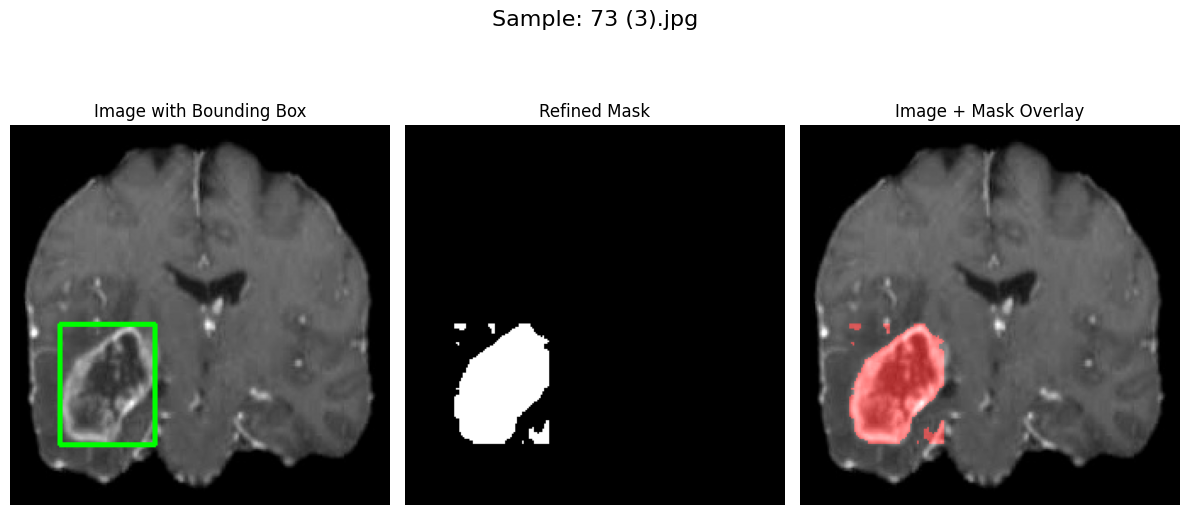

In [11]:
visualize_image_mask_overlay(df_train)

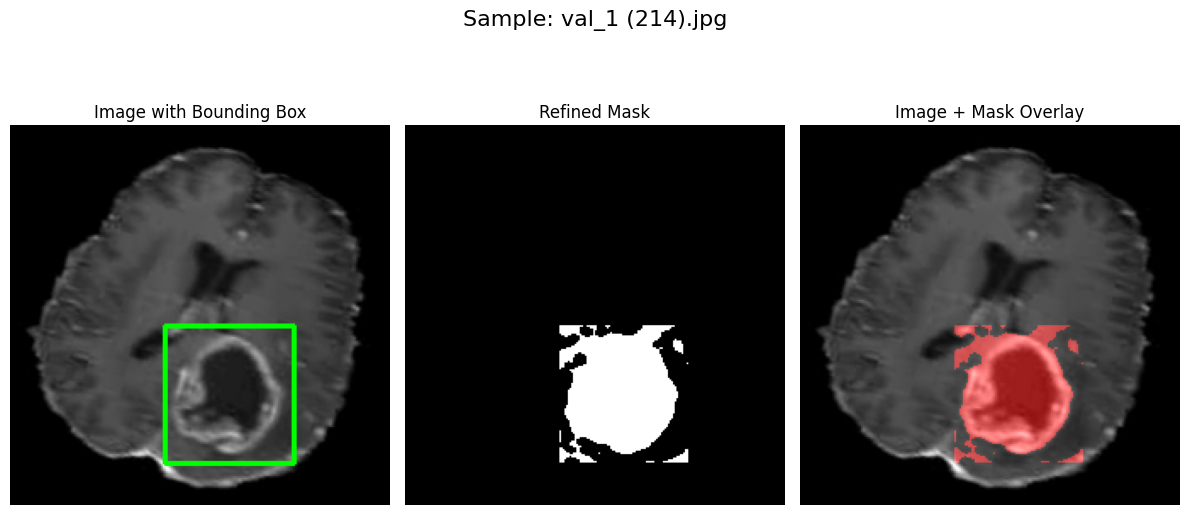

In [12]:
visualize_image_mask_overlay(df_valid)

# MODEL BUILDING

## MODEL 1

### DATASET GENERATION

In [13]:
# Create a data generator which scales the data from 0 to 1
image_datagen = ImageDataGenerator(rescale=1./255)
mask_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
batch_size = 16

image_generator_train = image_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='image_path',
    class_mode=None, # Since default is categorical
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    shuffle=False # Since default is True
)

mask_generator_train = mask_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='mask_path',
    class_mode=None,
    color_mode='grayscale', # We don't specify this in image generator because we want the output to be in rgb format as resnet expects it in rgb and it's output is in grayscale
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    shuffle=False
)

image_generator_valid = image_datagen.flow_from_dataframe(
    dataframe=df_valid,
    x_col='image_path',
    class_mode=None,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    shuffle=False
)

mask_generator_valid = mask_datagen.flow_from_dataframe(
    dataframe=df_valid,
    x_col='mask_path',
    color_mode='grayscale',
    class_mode=None,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    shuffle=False
)

def combined_generator(image_gen, mask_gen):
    while True:
        X = next(image_gen)
        y = next(mask_gen)
        yield (X, y)

Found 878 validated image filenames.
Found 878 validated image filenames.
Found 223 validated image filenames.
Found 223 validated image filenames.


In [15]:
train_generator = combined_generator(image_generator_train, mask_generator_train)
valid_generator = combined_generator(image_generator_valid, mask_generator_valid)

### MODEL

In [16]:
def dice_coefficient(y_true, y_pred, smooth=1e-7):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def iou_metric(y_true, y_pred, smooth=1e-7):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice_loss = 1 - dice_coefficient(y_true, y_pred)
    return bce + dice_loss

In [20]:
# Get the ResNet50 base model
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='keras_tensor')
basemodel = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)
#basemodel.summary()
# Freeze the model weights
#for layer in basemodel.layers:
 # layer.trainable = False

In [21]:
# Get feature maps from intermediate layers for skip connections
skip1 = basemodel.get_layer("conv1_relu").output
skip2 = basemodel.get_layer("conv2_block3_out").output
skip3 = basemodel.get_layer("conv3_block4_out").output
skip4 = basemodel.get_layer("conv4_block6_out").output
x = basemodel.get_layer("conv5_block3_out").output  # bottleneck

# Decoder
def up_block(x, skip, filters):
    x = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(x)
    x = Concatenate()([x, skip])
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = Dropout(0.3)(x)
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    return x

x = up_block(x, skip4, 512)
x = up_block(x, skip3, 256)
x = up_block(x, skip2, 128)
x = up_block(x, skip1, 64)

# Final upsampling to original size
x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)

segmentation_model = Model(inputs=inputs, outputs=outputs)
segmentation_model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coefficient, iou_metric])


In [22]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

history = segmentation_model.fit(
    train_generator,
    steps_per_epoch=len(df_train) // batch_size,
    validation_data=valid_generator,
    validation_steps=len(df_valid) // batch_size,
    epochs=50,
    callbacks=callbacks
)
segmentation_model.save("/content/drive/MyDrive/Colab Notebooks/segmentation_model.keras")

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 111s 885ms/step - dice_coefficient: 0.2595 - iou_metric: 0.1698 - loss: 0.9518 - val_dice_coefficient: 0.0247 - val_iou_metric: 0.0125 - val_loss: 207.5970
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 720ms/step - dice_coefficient: 0.6541 - iou_metric: 0.4901 - loss: 0.4440 - val_dice_coefficient: 9.8754e-05 - val_iou_metric: 4.9380e-05 - val_loss: 1.3234
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 539ms/step - dice_coefficient: 0.7338 - iou_metric: 0.5826 - loss: 0.3330 - val_dice_coefficient: 1.2156e-05 - val_iou_metric: 6.0781e-06 - val_loss: 1.3711
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 366ms/step - dice_coefficient: 0.7700 - iou_metric: 0.6290 - loss: 0.2894 - val_dice_coefficient: 4.5258e-06 - val_iou_metric: 2.2629e-06 - val_loss: 1.4202
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 380ms/step - dice_coefficient: 0.7900 - iou_metric: 0.6546 - loss: 0.2625 - val_dice_coefficient: 3.4816e-07 - val_iou_metric: 1.7408e-07 - val_loss: 1.5238
Epoch 6/50

### EVALUATION

In [23]:
results = segmentation_model.evaluate(valid_generator, steps=len(df_valid) // batch_size)
metric_names = segmentation_model.metrics_names  # ['loss', 'dice_coefficient', 'iou_metric']

for name, value in zip(metric_names, results):
    print(f"{name}: {value:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - dice_coefficient: 0.7422 - iou_metric: 0.5950 - loss: 0.3494
loss: 0.3142
compile_metrics: 0.7621


In [24]:
def visualize_segmentation(image, true_mask, pred_mask, threshold=0.5, figsize=(15, 6)):
    pred_mask_thresh = (pred_mask > threshold).astype('float32')
    pred_mask_vis = (pred_mask_thresh.squeeze() * 255).astype(np.uint8)

    # Ensure 3-channel RGB for image
    image_rgb = image.copy()
    if image_rgb.shape[-1] == 1:
        image_rgb = np.repeat(image_rgb, 3, axis=-1)
    elif image_rgb.shape[-1] == 3 and image_rgb.max() <= 1.0:
        image_rgb = (image_rgb * 255).astype(np.uint8)

    # Create red-colored mask (only Red channel active)
    red_mask = np.zeros_like(image_rgb)
    red_mask[:, :, 0] = pred_mask_vis

    # Blend using OpenCV-style overlay
    overlay = cv2.addWeighted(image_rgb, 1.0, red_mask, 0.5, 0)

    plt.figure(figsize=figsize)

    plt.subplot(1, 4, 1)
    plt.imshow(image_rgb)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(true_mask.squeeze(), cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(pred_mask_thresh.squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(overlay)
    plt.title("Overlay")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


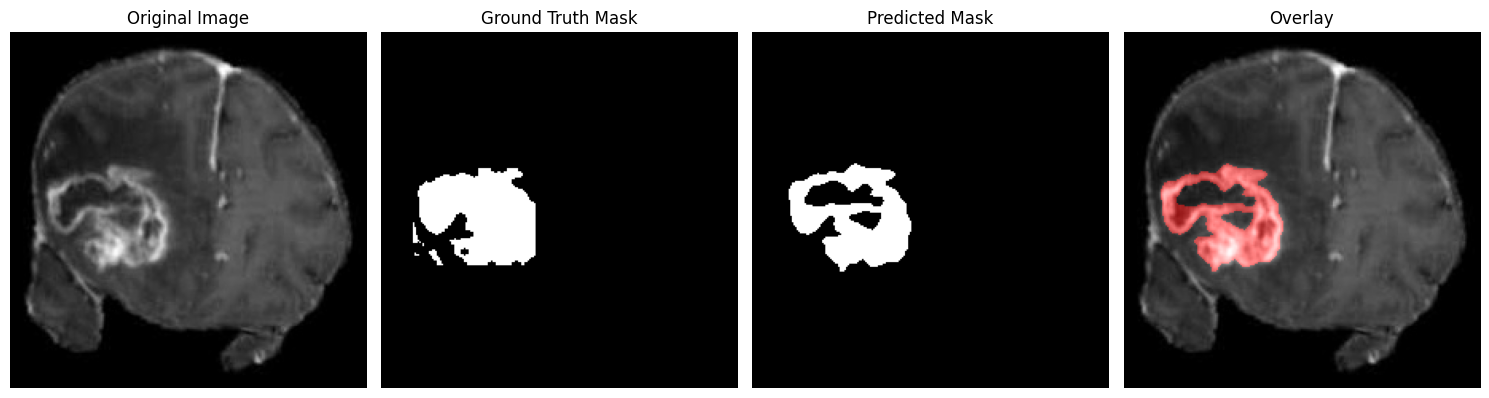

In [25]:
# Get a batch of validation images and masks
val_imgs, val_masks = next(valid_generator)

# Predict on the batch
pred_masks = segmentation_model.predict(val_imgs)

# Visualize a sample
idx = 3  # Any index within the batch
visualize_segmentation(val_imgs[idx], val_masks[idx], pred_masks[idx])

## MODEL 2

### DATASET GENERATION

In [26]:
# Update df_train and df_valid to include label
df_train['label'] = df_train['class_ids'].apply(lambda ids: 1 if 1 in ids else 0)
df_valid['label'] = df_valid['class_ids'].apply(lambda ids: 1 if 1 in ids else 0)

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator_cls = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='image_path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='raw',  # outputs raw float labels (good for binary)
    batch_size=batch_size,
    shuffle=True
)

valid_generator_cls = valid_datagen.flow_from_dataframe(
    dataframe=df_valid,
    x_col='image_path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='raw',
    batch_size=batch_size,
    shuffle=False
)
# Save filenames from the training/validation generators
train_image_names_cls = train_generator_cls.filenames
val_image_names_cls = valid_generator_cls.filenames

Found 878 validated image filenames.
Found 223 validated image filenames.


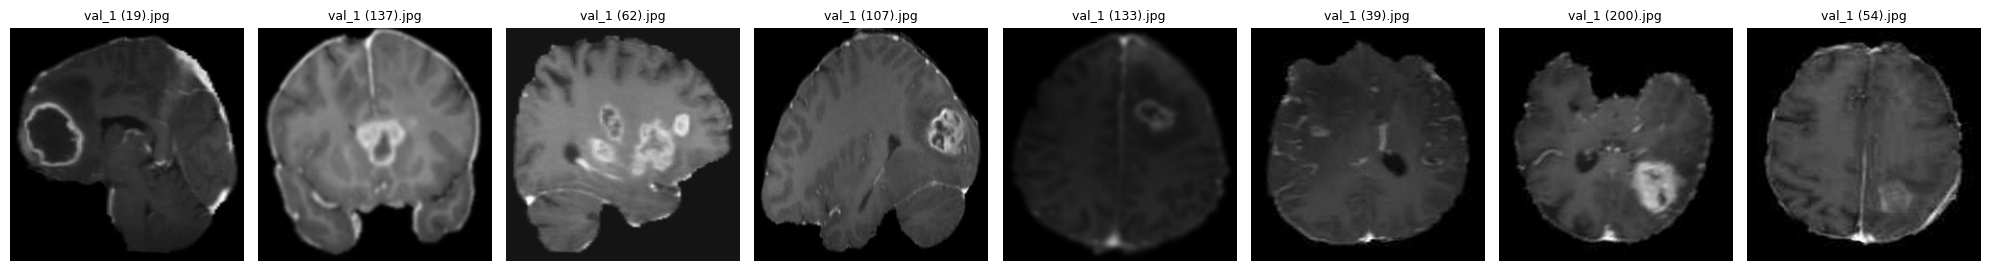

In [27]:
def visualize_batch_from_generator(generator, image_names, num=8):
    generator.reset()
    X_batch, _ = next(generator)

    plt.figure(figsize=(20, 4))
    for i in range(min(num, len(X_batch))):
        plt.subplot(1, num, i + 1)
        plt.imshow(X_batch[i])
        name = image_names[i].split("/")[-1]
        plt.title(name, fontsize=9)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Example usage
visualize_batch_from_generator(valid_generator_cls, val_image_names_cls)

### MODEL

In [28]:
def binary_focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        bce = binary_crossentropy(y_true, y_pred)
        bce_exp = tf.math.exp(-bce)
        focal_loss = alpha * tf.math.pow((1 - bce_exp), gamma) * bce
        return focal_loss
    return focal_loss

def build_crop_classifier_model(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    # Freeze the model weights
    base_model.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(1e-4), loss=binary_focal_loss(gamma=2.0, alpha=0.25), metrics=['accuracy'])
    return model

classifier_model = build_crop_classifier_model()

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = classifier_model.fit(
    train_generator_cls,
    validation_data=valid_generator_cls,
    steps_per_epoch=len(df_train) // batch_size,
    validation_steps=len(df_valid) // batch_size,
    epochs=50,
    callbacks=[early_stop]
)
classifier_model.save("/content/drive/MyDrive/Colab Notebooks/classification_model.keras")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 193ms/step - accuracy: 0.5340 - loss: 0.0794 - val_accuracy: 0.5240 - val_loss: 0.0470
Epoch 2/50
 1/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5625 - loss: 0.0509

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5625 - loss: 0.0509 - val_accuracy: 0.5240 - val_loss: 0.0472
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5482 - loss: 0.0538 - val_accuracy: 0.5240 - val_loss: 0.0449
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5625 - loss: 0.0479 - val_accuracy: 0.5144 - val_loss: 0.0450
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.5814 - loss: 0.0457 - val_accuracy: 0.5385 - val_loss: 0.0435
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4375 - loss: 0.0521 - val_accuracy: 0.5337 - val_loss: 0.0433
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5998 - loss: 0.0434 - val_accuracy: 0.5625 - val_loss: 0.0428
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3125 - loss: 0.0669 - val_accuracy: 0.5625 - val_loss: 0.0429
Epoch 9/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.6108 - loss: 0.0416 - val_accuracy: 0.5865 - val_loss: 0.04

### EVALUATION

In [29]:
# Get all predictions
y_pred_probs = classifier_model.predict(valid_generator_cls, verbose=1)
y_pred_cls = (y_pred_probs > 0.47).astype(int).flatten()

# Rebuild ground truth (valid_generator_cls yields in same order)
y_true_cls = valid_generator_cls.labels

# Classification metrics
print("Classification Report:")
print(classification_report(y_true_cls, y_pred_cls, target_names=["Benign", "Malignant"]))
print("Confusion Matrix:")
print(confusion_matrix(y_true_cls, y_pred_cls))
print("ROC AUC Score:", roc_auc_score(y_true_cls, y_pred_probs))

14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 333ms/step
Classification Report:
              precision    recall  f1-score   support

      Benign       0.76      0.61      0.68       142
   Malignant       0.49      0.65      0.56        81

    accuracy                           0.63       223
   macro avg       0.62      0.63      0.62       223
weighted avg       0.66      0.63      0.63       223

Confusion Matrix:
[[87 55]
 [28 53]]
ROC AUC Score: 0.6663189010606851


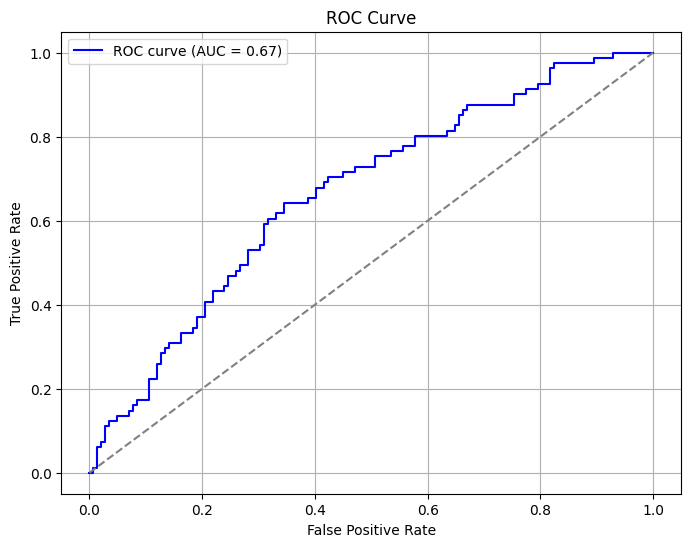

In [30]:
fpr, tpr, thresholds = roc_curve(y_true_cls, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
youden_index = tpr - fpr
best_index = np.argmax(youden_index)
best_threshold = thresholds[best_index]

print(f"🔥 Best threshold by Youden’s J: {best_threshold:.2f}")


🔥 Best threshold by Youden’s J: 0.47


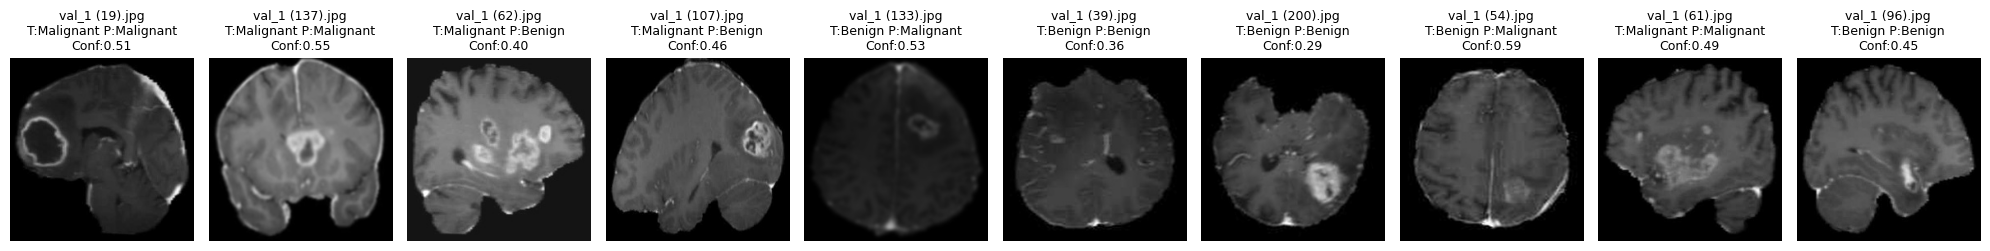

In [32]:
def visualize_predictions_with_names(generator, y_true, y_pred, y_prob, image_names, class_names={0: 'Benign', 1: 'Malignant'}, num=10):
    generator.reset()
    X_batch, _ = next(generator)

    plt.figure(figsize=(20, 4))
    for i in range(min(num, len(X_batch))):
        plt.subplot(1, num, i + 1)
        plt.imshow(X_batch[i])
        name = image_names[i].split("/")[-1]
        true_label = class_names[y_true[i]]
        pred_label = class_names[y_pred[i]]
        confidence = f"{y_prob[i]:.2f}"
        title = f"{name}\nT:{true_label} P:{pred_label}\nConf:{confidence}"
        plt.title(title, fontsize=9)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Usage
visualize_predictions_with_names(valid_generator_cls, y_true_cls, y_pred_cls, y_pred_probs.flatten(), val_image_names_cls)